In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import itertools
import random

### Implementare propriu zisa pentru CNN si ANN

In [16]:
# ReLU și derivata
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

# Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Funcția de pierdere: Binary Cross Entropy
def binary_cross_entropy(y_true, y_pred):
    eps = 1e-9
    return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

class SimpleANN:
    def __init__(self, input_size, hidden_size):
        # Inițializare cu He pentru ReLU
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, 1) * np.sqrt(2 / hidden_size)
        self.b2 = np.zeros((1, 1))

        self.loss_history = []
        self.accuracy_history = []

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, y_pred, learning_rate=0.01):
        m = X.shape[0]  # număr de exemple

        # Derivată combinată BCE + Sigmoid: y_pred - y
        dz2 = y_pred - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * relu_deriv(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Actualizare greutăți
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, X, y, epochs=1000, learning_rate=0.01):
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = binary_cross_entropy(y, y_pred)
            self.backward(X, y, y_pred, learning_rate)

            # Acuratețea (0.5 prag)
            acc = np.mean((y_pred > 0.5) == y)
            self.loss_history.append(loss)
            self.accuracy_history.append(acc)

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f"Epoca {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

    def plot_loss_and_accuracy(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.title('Evoluția pierderii în timpul antrenării')
        plt.xlabel('Epoci')
        plt.ylabel('Pierdere')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_history, label='Accuracy')
        plt.title('Evoluția acurateței în timpul antrenării')
        plt.xlabel('Epoci')
        plt.ylabel('Acuratețe')
        plt.legend()

        plt.tight_layout()
        plt.show()

class SimpleCNN:
    def __init__(self, input_shape, kernel_size=3, pool_size=2):
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.pool_size = pool_size

        self.kernel = np.random.randn(self.kernel_size, self.kernel_size, 3)  # Kernel pentru 3 canale
        self.bias_conv = 0.0

        conv_output_size = (input_shape[0] - kernel_size + 1) // pool_size
        self.fc_input_dim = conv_output_size * conv_output_size

        self.fc_weights = np.random.randn(self.fc_input_dim, 1)
        self.fc_bias = 0.0
        self.loss_history = []  # istoric pierdere
        self.accuracy_history = []  # istoric acuratete

    def convolve(self, image):
        h, w, c = image.shape  # Înălțime, lățime, canale
        kh = self.kernel_size
        out = np.zeros((h - kh + 1, w - kh + 1))

        for i in range(h - kh + 1):
            for j in range(w - kh + 1):
                region = image[i:i+kh, j:j+kh, :]  # Selectăm regiunea pentru toate canalele
                out[i, j] = np.sum(region * self.kernel) + self.bias_conv
        return out

    def max_pool(self, feature_map):
        pool_h = pool_w = self.pool_size
        h, w = feature_map.shape
        out_h, out_w = h // pool_h, w // pool_w
        pooled = np.zeros((out_h, out_w))

        for i in range(out_h):
            for j in range(out_w):
                region = feature_map[i*pool_h:(i+1)*pool_h, j*pool_w:(j+1)*pool_w]
                pooled[i, j] = np.max(region)
        return pooled

    def flatten(self, pooled):
        return pooled.flatten()

    def forward(self, image):
        self.input = image
        self.conv_out = self.convolve(image)
        self.relu_out = relu(self.conv_out)
        self.pooled = self.max_pool(self.relu_out)
        self.flattened = self.flatten(self.pooled)
        self.fc_z = np.dot(self.flattened, self.fc_weights) + self.fc_bias
        self.output = sigmoid(self.fc_z)
        return self.output

    def backward(self, y_true, learning_rate=0.01):
        d_loss = self.output - y_true
        d_fc_weights = np.dot(self.flattened[:, np.newaxis], d_loss[np.newaxis])
        d_fc_bias = d_loss

        self.fc_weights -= learning_rate * d_fc_weights
        self.fc_bias -= learning_rate * d_fc_bias

    def train(self, X, y, epochs=10, learning_rate=0.01):
        for epoch in range(epochs):
            losses = []
            correct = 0
            for i in range(len(X)):
                out = self.forward(X[i])
                loss = binary_cross_entropy(y[i], out)
                losses.append(loss)
                pred = int(out > 0.5)
                correct += (pred == y[i])
                self.backward(y[i], learning_rate)
            avg_loss = np.mean(losses)
            accuracy = correct / len(X)
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(accuracy)

            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    def plot_loss_and_accuracy(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.title('Evoluția pierderii în timpul antrenării')
        plt.xlabel('Epoci')
        plt.ylabel('Pierdere')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_history, label='Accuracy')
        plt.title('Evoluția acurateței în timpul antrenării')
        plt.xlabel('Epoci')
        plt.ylabel('Acuratețe')
        plt.legend()

        plt.tight_layout()
        plt.show()



### Utils pentru poze si aplicarea de filtre sepia pe unele dintre ele + load data function

In [3]:
def apply_sepia_filter(image):
    # matricea de transformare pentru filtrul sepia
    sepia_kernel = np.array([
        [0.393, 0.769, 0.189],
        [0.349, 0.686, 0.168],
        [0.272, 0.534, 0.131]
    ])
    
    # aplicam transformarea
    sepia_img = np.dot(image, sepia_kernel.T)
    
    # limitam valorile la intervalul [0, 255]
    sepia_img = np.clip(sepia_img, 0, 255).astype(np.uint8)
    
    return sepia_img

def create_dataset(source_dir, target_dir, num_images=100, img_size=(128, 128)):
    
    # cream directoarele pentru setul de date
    os.makedirs(f"{target_dir}/normal", exist_ok=True)
    os.makedirs(f"{target_dir}/sepia", exist_ok=True)
    
    # obtinem lista de fisiere din directorul sursa
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) < num_images*2:
        print(f"ATENȚIE: Doar {len(image_files)} imagini disponibile, mai puține decât cele {num_images*2} necesare.")
        num_images = len(image_files) // 2
    
    # selectam aleatoriu imaginile pentru setul nostru de date
    selected_files = random.sample(image_files, num_images * 2)
    
    # primele num_images vor fi normale, următoarele vor primi filtru sepia
    normal_files = selected_files[:num_images]
    sepia_files = selected_files[num_images:2*num_images]
    
    print("Procesăm imaginile normale...")
    for i, file in enumerate(tqdm(normal_files)):
        try:
            # Citim imaginea și o redimensionăm
            img = cv2.imread(os.path.join(source_dir, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertim din BGR în RGB
            img = cv2.resize(img, img_size)
            
            # Salvăm imaginea normală
            plt.imsave(f"{target_dir}/normal/normal_{i}.jpg", img)
        except Exception as e:
            print(f"Eroare la procesarea {file}: {e}")
    
    print("Procesam imaginile cu filtru sepia...")
    for i, file in enumerate(tqdm(sepia_files)):
        try:
            # Citim imaginea si o redimensionăm
            img = cv2.imread(os.path.join(source_dir, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertim din BGR în RGB
            img = cv2.resize(img, img_size)
            
            # Aplicam filtrul sepia
            sepia_img = apply_sepia_filter(img)
            
            # Salvăm imaginea cu filtru sepia
            plt.imsave(f"{target_dir}/sepia/sepia_{i}.jpg", sepia_img)
        except Exception as e:
            print(f"Eroare la procesarea {file}: {e}")
    
    print(f"Set de date creat cu {num_images} imagini normale si {num_images} imagini cu filtru sepia.")


def load_dataset(data_dir, img_size=(128, 128)):
    X = []  
    y = [] 
    
    # incarcam imaginile normale (clasa 0)
    print("Încărcăm imaginile normale...")
    normal_dir = os.path.join(data_dir, 'normal')
    for filename in tqdm(os.listdir(normal_dir)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(normal_dir, filename)
            try:
                # citim imaginea, o redimensionam si o aplatizam
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertim din BGR în RGB
                img = cv2.resize(img, img_size)
                img_flat = img.flatten() / 255.0  # normalizam valorile in [0, 1]
                
                X.append(img_flat)
                y.append(0)  # eticheta pentru imagini normale
            except Exception as e:
                print(f"Eroare la încărcarea {img_path}: {e}")
    
    # incarcam imaginile cu filtru sepia (clasa 1)
    print("Incarcam imaginile cu filtru sepia...")
    sepia_dir = os.path.join(data_dir, 'sepia')
    for filename in tqdm(os.listdir(sepia_dir)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(sepia_dir, filename)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
                img = cv2.resize(img, img_size)
                img_flat = img.flatten() / 255.0  
                X.append(img_flat)
                y.append(1)  # eticheta pentru imagini cu sepia
            except Exception as e:
                print(f"Eroare la incarcarea {img_path}: {e}")
    
    return np.array(X), np.array(y)

### Vizualizarea unei imagini si speia filter

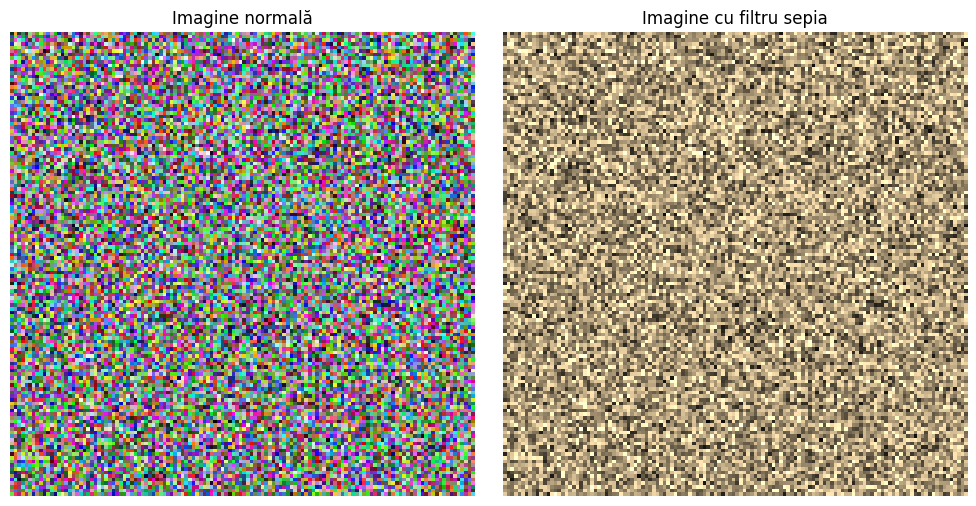

In [4]:
def visualize_sample_images():
    """
    Generează și vizualizează câteva imagini de exemplu cu filtru normal și sepia
    """
    # Generăm o imagine aleatoare pentru demonstrație
    img = np.random.randint(0, 255, (128, 128, 3), dtype=np.uint8)
    
    # Aplicăm filtrul sepia
    sepia_img = apply_sepia_filter(img)
    
    # Afișăm imaginile
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title('Imagine normală')
    ax[0].axis('off')
    
    ax[1].imshow(sepia_img)
    ax[1].set_title('Imagine cu filtru sepia')
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_sample_images()

### Train model pentru ANN + plotare matrice de confuzie + plotare learning curves

In [5]:
def split_and_normalize_data(X, y, test_size=0.2, random_state=42):
    # impărțim datele
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Normalizăm datele (deși am făcut deja o normalizare la încărcare,
    # este o practică bună să le standardizăm)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

def train_and_evaluate_model(X_train, X_test, y_train, y_test, hidden_layer_sizes=(100,), 
                           max_iter=200, activation='relu', learning_rate_init=0.001, 
                           solver='adam', verbose=True):
    
    # Inițializăm modelul
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        activation=activation,
        solver=solver,
        learning_rate_init=learning_rate_init,
        random_state=42,
        verbose=verbose
    )
    
    # Antrenăm modelul
    model.fit(X_train, y_train)
    
    # Facem predicții pe setul de test
    y_pred = model.predict(X_test)
    
    # Calculăm metrici de performanță
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    
    # Afișăm matricea de confuzie
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Normal', 'Sepia'], 'Sepia Filter Classification')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return model, accuracy, precision, recall

def plot_confusion_matrix(cm, class_names, title):
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Afișăm valorile în celule
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_learning_curves(model, X_train, X_test, y_train, y_test):
    
    if not hasattr(model, 'loss_curve_'):
        print("Modelul nu suportă vizualizarea curbei de pierdere.")
        return
    
    plt.figure(figsize=(12, 4))
    
    # Curba de pierdere
    plt.subplot(1, 2, 1)
    plt.plot(model.loss_curve_)
    plt.title('Curba de pierdere')
    plt.xlabel('Iterații')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Acuratețea pe seturile de antrenare și testare
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, test_scores = [], [], []
    
    for i, size in enumerate(train_sizes):
        n_samples = int(X_train.shape[0] * size)
        model_temp = MLPClassifier(hidden_layer_sizes=model.hidden_layer_sizes,
                                  max_iter=model.max_iter,
                                  activation=model.activation,
                                  solver=model.solver,
                                  learning_rate_init=model.learning_rate_init,
                                  random_state=42)
        model_temp.fit(X_train[:n_samples], y_train[:n_samples])
        train_scores.append(model_temp.score(X_train[:n_samples], y_train[:n_samples]))
        test_scores.append(model_temp.score(X_test, y_test))
        train_sizes_abs.append(n_samples)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, train_scores, 'o-', label='Antrenare')
    plt.plot(train_sizes, test_scores, 'o-', label='Testare')
    plt.title('Curbe de învățare')
    plt.xlabel('Proporția datelor de antrenare')
    plt.ylabel('Acuratețe')
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



### Train model pentru CNN + plotare matrice de confuzie + plotare learning curves

In [6]:
def train_and_evaluate_cnn(X_train, X_test, y_train, y_test, 
                           input_shape=(64, 64, 3), 
                           epochs=10, batch_size=32, learning_rate=0.001, 
                           verbose=1):
    
    # Normalizează imaginile (asumăm valori între 0-255)
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Creează modelul CNN
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Clasificare binară
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Antrenează modelul
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.2, verbose=verbose)
    
    # Preziceri pe setul de test
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calcul metrici
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Normal', 'Sepia'], 'Sepia Filter Classification')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return model, accuracy, precision, recall


def plot_cnn_learning_curves(create_model_fn, X_train, y_train, X_test, y_test, batch_size=32, epochs=5):
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_accuracies = []
    test_accuracies = []
    train_sizes_abs = []

    for size in train_sizes:
        n_samples = int(X_train.shape[0] * size)
        X_train_subset = X_train[:n_samples]
        y_train_subset = y_train[:n_samples]

        # Construim un model CNN nou (neantrenat)
        model = create_model_fn()
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        # Antrenăm modelul pe subsetul curent
        history = model.fit(X_train_subset, y_train_subset,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)

        # Evaluăm modelul
        train_loss, train_acc = model.evaluate(X_train_subset, y_train_subset, verbose=0)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_sizes_abs.append(n_samples)

        print(f"Proporție: {size:.1f} => Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

    # Plotăm curbele
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, train_accuracies, 'o-', label='Antrenare')
    plt.plot(train_sizes_abs, test_accuracies, 'o-', label='Testare')
    plt.title('Curbe de învățare pentru CNN')
    plt.xlabel('Număr imagini pentru antrenare')
    plt.ylabel('Acuratețe')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Influenta (hyper)parametrilor asupra calitatii clasificatorului antrenat.

In [ ]:
def hyperparameter_tuning(X_train, X_test, y_train, y_test):
    
    # configuratiile de testat
    hidden_layers = [(50,), (100,)]
    activations = ['relu', 'tanh']
    learning_rates = [0.001, 0.01]
    solvers = ['adam']
    
    # vom stoca rezultatele aici
    results = []
    
    best_accuracy = 0
    best_model = None
    best_config = None
    
    print("Incepem experimentele cu hiperparametri...")
    
    for hl in hidden_layers:
        for act in activations:
            for lr in learning_rates:
                for solver in solvers:
                    print(f"\nTestam configuratia: {hl}, {act}, {lr}, {solver}")
                    
                    model = MLPClassifier(
                        hidden_layer_sizes=hl,
                        max_iter=200,
                        activation=act,
                        solver=solver,
                        learning_rate_init=lr,
                        random_state=42,
                        verbose=False
                    )
                    
                    # antrenam modelul
                    model.fit(X_train, y_train)
                    
                    # evaluam pe setul de test
                    y_pred = model.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred, average='binary')
                    recall = recall_score(y_test, y_pred, average='binary')
                    
                    results.append({
                        'hidden_layers': hl,
                        'activation': act,
                        'learning_rate': lr,
                        'solver': solver,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall
                    })
                    
                    print(f"Acuratete: {accuracy:.4f}")
                    
                    # salvam cel mai bun model
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model = model
                        best_config = (hl, act, lr, solver)
    
    print("\nCel mai bun model:")
    print(f"Configuratie: {best_config}")
    print(f"Acuratete: {best_accuracy:.4f}")
    
    # afisam matricea de confuzie pentru cel mai bun model
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Normal', 'Sepia'], 'Cea mai bună clasificare Sepia Filter')
    
    # afisam curbele de invatare pentru cel mai bun model
    plot_learning_curves(best_model, X_train, X_test, y_train, y_test)
    
    return results, best_model

### Antrenare si rulare cu ANN si CNN cu implementare proprie

Simulăm încărcarea setului de date...
Încărcăm imaginile normale...


100%|██████████| 25/25 [00:00<00:00, 1000.00it/s]


Incarcam imaginile cu filtru sepia...


100%|██████████| 25/25 [00:00<00:00, 833.20it/s]

ANN propriu:


CNN propriu:


C:\Users\Admin\AppData\Local\Temp\ipykernel_2176\1557670987.py:159: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(out > 0.5)


Epoch 1: Loss = 0.6921, Accuracy = 0.5250
Epoch 2: Loss = 0.6921, Accuracy = 0.5500
Epoch 3: Loss = 0.6920, Accuracy = 0.5500
Epoch 4: Loss = 0.6920, Accuracy = 0.5250
Epoch 5: Loss = 0.6920, Accuracy = 0.5000
Epoch 6: Loss = 0.6920, Accuracy = 0.5250
Epoch 7: Loss = 0.6919, Accuracy = 0.5000
Epoch 8: Loss = 0.6919, Accuracy = 0.4750
Epoch 9: Loss = 0.6919, Accuracy = 0.4750
Epoch 10: Loss = 0.6919, Accuracy = 0.4750


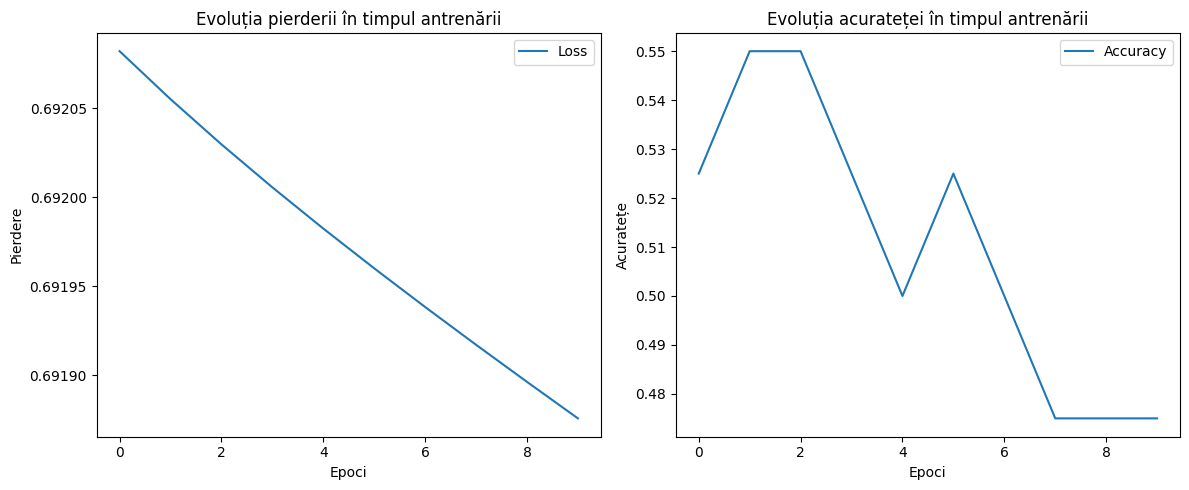

In [ ]:
IMG_SIZE = (128, 128)
#create_dataset(source_dir="./images", 
                     # target_dir="sepia_dataset", 
                      #num_images=50, 
                      #img_size=IMG_SIZE)
print("Simulăm încărcarea setului de date...")
num_samples = 1000
feature_size = IMG_SIZE[0] * IMG_SIZE[1] * 3  # Numărul total de caracteristici (pixeli * canale)
    
# generam date aleatorii pt demonstratie
X, y = load_dataset(data_dir="sepia_dataset", img_size=IMG_SIZE)
    
# 3. impartim si normalizam datele
X_train, X_test, y_train, y_test = split_and_normalize_data(X, y)

print("ANN propriu:")
# vizualizam rezultatele pentru ANN
ann = SimpleANN(input_size=feature_size, hidden_size=100)
#ann.train(X_train, y_train, epochs=100, learning_rate=0.01)
#ann.plot_loss_and_accuracy()  # afisam pierderea si acuratetea

print("CNN propriu:")

# vizualizam rezultatele pentru CNN
cnn = SimpleCNN(input_shape=IMG_SIZE)
# reconstruim imaginile la forma originala
X2 = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)

# Împărțim datele în seturi de antrenare și testare
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.2, random_state=42, stratify=y
    
)

# normalizam valorile pixelilor la intervalul [0, 1]
X2_train = X2_train / 255.0
X2_test = X2_test / 255.0
cnn.train(X2_train, y2_train, epochs=10, learning_rate=0.01)
cnn.plot_loss_and_accuracy() # afisam pierderea si acuratetea


    

### Implementare CNN si ANN folosind tool-urile aferente


=== Antrenarea ANN modelului initial ===


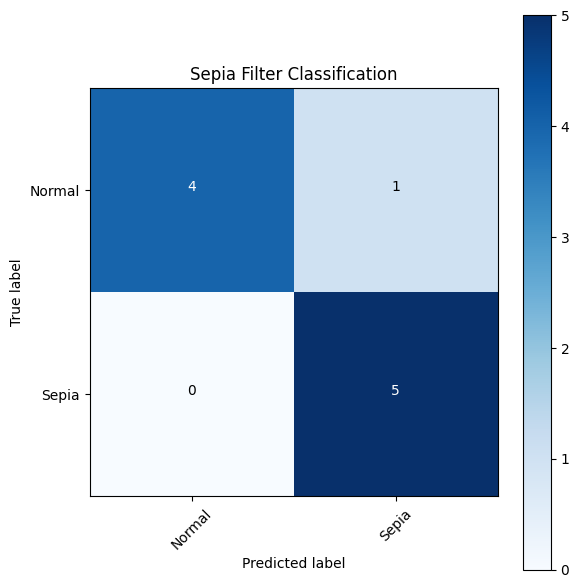

Accuracy: 0.9000
Precision: 0.8333
Recall: 1.0000
Acuratețe: 0.9000
Precizie: 0.8333
Recall: 1.0000

=== Antrenarea CNN modelului initial ===


d:\facultate\semestrul 4\ai\lab7_ai\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 0.6931 - val_accuracy: 0.2500 - val_loss: 0.6943
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step - accuracy: 0.5625 - loss: 0.6928 - val_accuracy: 0.2500 - val_loss: 0.7115
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.5625 - loss: 0.6907 - val_accuracy: 0.2500 - val_loss: 0.7477
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step - accuracy: 0.5625 - loss: 0.6787 - val_accuracy: 0.2500 - val_loss: 0.8060
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step - accuracy: 0.5625 - loss: 0.6894 - val_accuracy: 0.2500 - val_loss: 0.8083
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.5625 - loss: 0.6726 - val_accuracy: 0.2500 - val_loss: 0.8045
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5625 - loss: 0.6982 - val_accuracy: 0.2500 - val_loss: 0.7771
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5625 - loss: 0.6942 - val_accuracy: 0.2500 - val_loss: 0.

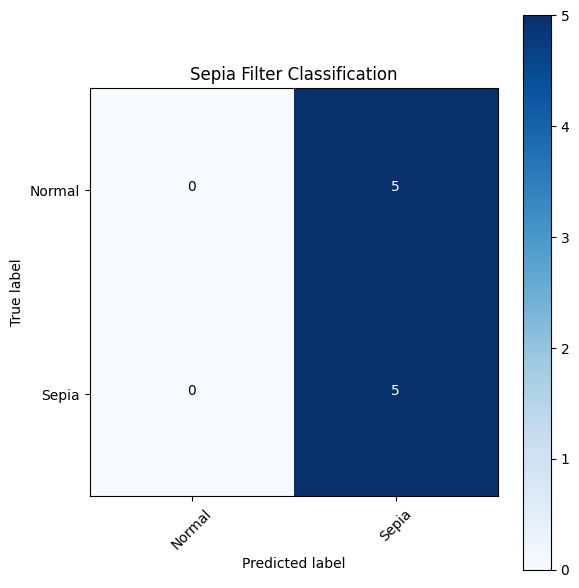

Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000

=== Experimentarea cu hiperparametri ===
Incepem experimentele cu hiperparametri...

Testam configuratia: (50,), relu, 0.001, adam
Acuratețe: 0.8000

Testam configuratia: (50,), relu, 0.01, adam
Acuratețe: 0.9000

Testam configuratia: (50,), tanh, 0.001, adam
Acuratețe: 0.9000

Testam configuratia: (50,), tanh, 0.01, adam
Acuratețe: 0.9000

Testam configuratia: (100,), relu, 0.001, adam
Acuratețe: 0.9000

Testam configuratia: (100,), relu, 0.01, adam
Acuratețe: 0.9000

Testam configuratia: (100,), tanh, 0.001, adam


d:\facultate\semestrul 4\ai\lab7_ai\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acuratețe: 0.9000

Testam configuratia: (100,), tanh, 0.01, adam
Acuratețe: 0.7000

Cel mai bun model:
Configuratie: ((50,), 'relu', 0.01, 'adam')
Acuratete: 0.9000


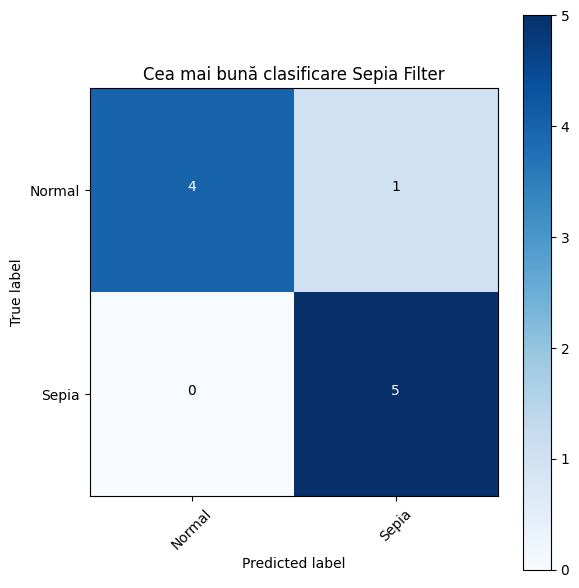

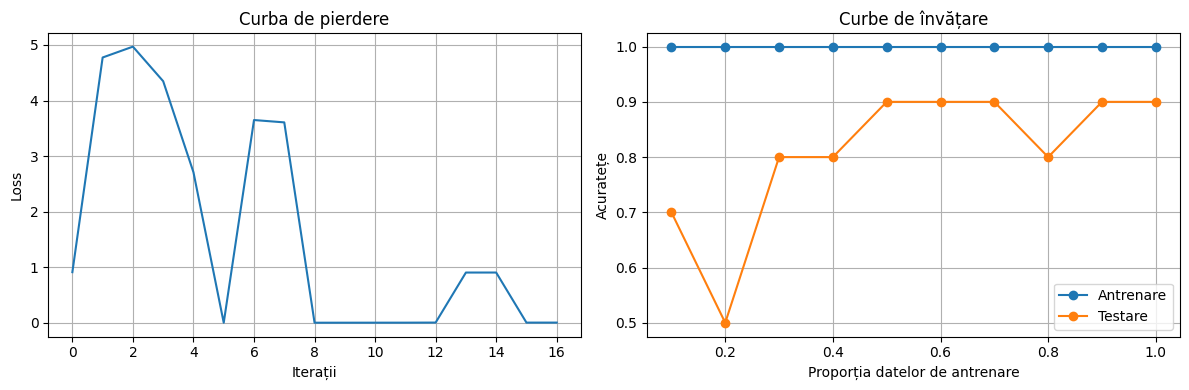

Best model: MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01,
              random_state=42)
Rezultate: [{'hidden_layers': (50,), 'activation': 'relu', 'learning_rate': 0.001, 'solver': 'adam', 'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8}, {'hidden_layers': (50,), 'activation': 'relu', 'learning_rate': 0.01, 'solver': 'adam', 'accuracy': 0.9, 'precision': 0.8333333333333334, 'recall': 1.0}, {'hidden_layers': (50,), 'activation': 'tanh', 'learning_rate': 0.001, 'solver': 'adam', 'accuracy': 0.9, 'precision': 0.8333333333333334, 'recall': 1.0}, {'hidden_layers': (50,), 'activation': 'tanh', 'learning_rate': 0.01, 'solver': 'adam', 'accuracy': 0.9, 'precision': 0.8333333333333334, 'recall': 1.0}, {'hidden_layers': (100,), 'activation': 'relu', 'learning_rate': 0.001, 'solver': 'adam', 'accuracy': 0.9, 'precision': 0.8333333333333334, 'recall': 1.0}, {'hidden_layers': (100,), 'activation': 'relu', 'learning_rate': 0.01, 'solver': 'adam', 'accuracy': 0.9, 'precision': 0.

In [20]:
# 4. Antrenam si evaluam modelul initial
print("\n=== Antrenarea ANN modelului initial ===")
initial_model, accuracy, precision, recall = train_and_evaluate_model(
    X_train, X_test, y_train, y_test,
    hidden_layer_sizes=(100,),
    max_iter=100,
    verbose=False
)
print(f"Acuratețe: {accuracy:.4f}")
print(f"Precizie: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# 4. Antrenam si evaluam modelul CNN
print("\n=== Antrenarea CNN modelului initial ===")
cnn_model, accuracy, precision, recall = train_and_evaluate_cnn(
    X2_train, X2_test, y2_train, y2_test,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    epochs=10,
    batch_size=32,
    learning_rate=0.001,
    verbose=1
)


# 5. Experimentăm cu diferiți hiperparametri
print("\n=== Experimentarea cu hiperparametri ===")
results, best_model = hyperparameter_tuning(X_train, X_test, y_train, y_test)  
print("Best model:", best_model)
print("Rezultate:", results)